# Tutorial 10: Ordinary Differential Equations (ODEs)

## Exercise 1: Forward and Backword Euler's

Let's try to solve the following non-linear scalar ODE for $t\in[0,20]s$ and a time step of $h = 0.01s$:

$$
\begin{cases}
y'(t) = e^{-y(t) t}+\cos(y(t)+t)\\
y(0) = 3
\end{cases}
$$

For the sake of simplicity, we will use the notation $y_i$ and $y_i'$ to indicate respectively $y(t_i)$ and $y'(t_i)$.  
This equation has no analytical solution, so we can have only numerical solutions.
We will try to solve it with both the Forward Euler's and Backward Euler's method.

### Forward Euler's method

Let's report here the basic formula for the Forward Euler's method:
$$y_{i+1}=y_{i}+h*f(t_{i},y_{i})$$

The Julia implementation is straight-forward:

In [1]:
# Define function for Forward Euler
function forEuler(f,t_in,t_end,y_in,h)
    
    # Define time array
    t = range(t_in,t_end,step=h);
    
    # Define output array
    y = [y_in];
    
    # Loop over all time instants
    for i = 2:length(t)
        y_new = y[end]+h*f(t[i-1],y[end]);
        append!(y,y_new)
    end
    
    # Return time and output
    return (t,y)
end

forEuler (generic function with 1 method)

We can use this function to solve the ODE above.

In this specific case, we have $h = 0.01s$, $t_0 = 0s$, $t_{end}=20s$, $y(t_0) = 3$ and:
$$f(t,y(t)) = e^{-y(t) t}+\cos(y(t)+t)$$

In [2]:
# Define function
f(t,y) = @. exp(- y * t) + cos(y + t);

# Define time limit and initial condition
t_in = 0.0;
t_end = 20.0;
h = 0.01;
y_in = 3.0;

# Apply Forward Euler's method
(t,y_for) = forEuler(f,t_in,t_end,y_in,h);

We can now plot our solution:

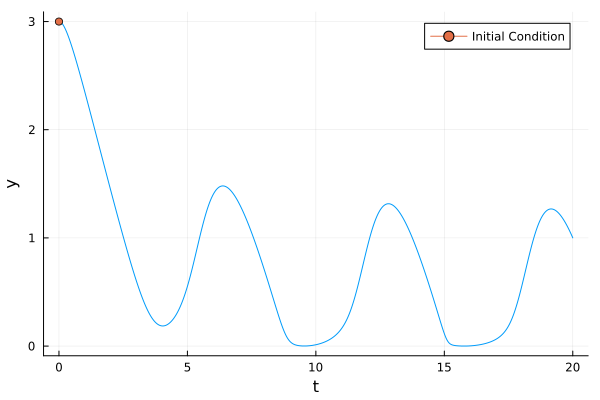

In [3]:
import Plots

Plots.plot(t,y_for,label="",xlabel="t",ylabel="y")
Plots.plot!([t_in],[y_in],label="Initial Condition",markershape=:circle)

## Backward Euler's method

Let's report here the basic formula for Backward Euler's method:
$$y_{i+1}=y_{i}+h*f(t_{i+1},y_{i+1})$$

In this case, $f$ is a non-linear function, so it's impossible to solve anylitically the equation above.  
We will use the Newton's method to find $y_{i+1}$ from the following equation at each timestep:
$$F(t_{i+1},y_{i},y_{i+1}) = y_{i}+h*f(t_{i+1},y_{i+1})-y_{i+1} = 0$$


To apply Newton's method, we need to derive this equation with respect to $y_{i+1}$:
$$F' = \frac{\partial F}{\partial y_{i+1}} = 0+h*\frac{\partial f}{\partial y}(t_{i+1},y_{i+1})-1$$

As initial guess for $y_{i+1}$, we will use $y_{i}$.  
We will use the same stopping criteria that we use in the tutorial two weeks ago: max iterations equal to 100 and tolerance on the solution update of $10^{-6}$.

In [4]:
function newton(f,df,x0,max_iter,toll)
    iter = 1;
    x_old = x0;
    x_new = x_old-f(x_old)/df(x_old);
    while iter <= max_iter && abs(x_new-x_old) >= toll
        x_old = x_new;
        x_new = x_old-f(x_old)/df(x_old);
        iter += 1;
    end
    return x_new;
end

function backEuler(f,df,t_in,t_end,y_in,h)
    
    # Define time array
    t = range(t_in,t_end,step=h);
    
    # Define output array
    y = [y_in];
    
    # Loop over all time instants
    for i = 2:length(t)
        
        # Define function and derivative for Newton's method
        y_old = y[i-1];
        F(y) = @. y_old + h * f(t[i],y) - y;
        dF(y) = @. h * df(t[i], y) - 1;
        
        # Apply Newton's method
        y_new = newton(F,dF,y[i-1],100,1e-6);
        append!(y,y_new)
    end
    
    # Return time and output
    return (t,y)
    
end

backEuler (generic function with 1 method)

In our case, this becomes:
$$F(t_{i+1},y_{i},y_{i+1}) = y_{i}+h(e^{-y_{i+1} t_{i+1}}+\cos(y_{i+1}+t_{i+1}))-y_{i+1} = 0$$
$$\frac{\partial f}{\partial y} = -t e^{-y t}-\sin(y+t)$$
$$F'(t_{i+1},y_{i+1}) = h\left(-t_{i+1} e^{-y_{i+1} t_{i+1}}-\sin(y_{i+1}+t_{i+1})\right)-1$$

In [5]:
# Define function
f(t,y) = @. exp(- y * t) + cos(y + t);
df(t,y) = @. - t * exp(- y * t) - sin(y + t);
#f(t,y) = @. - y + t;
#df(t,y) = @. -1;

# Define time limit and initial condition
t_in = 0.0;
t_end = 20.0;
h = 0.01;
y_in = 3.0;

# Apply Backward Euler's method
(t,y_back) = backEuler(f,df,t_in,t_end,y_in,h);

We can now plot our solution:

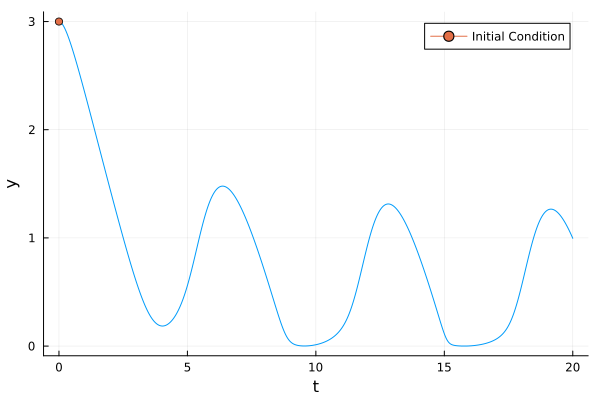

In [6]:
Plots.plot(t,y_back,label="",xlabel="t",ylabel="y")
Plots.plot!([t_in],[y_in],label="Initial Condition",markershape=:circle)

### Comparison of the two solutions

We can now plot together the two solutions:

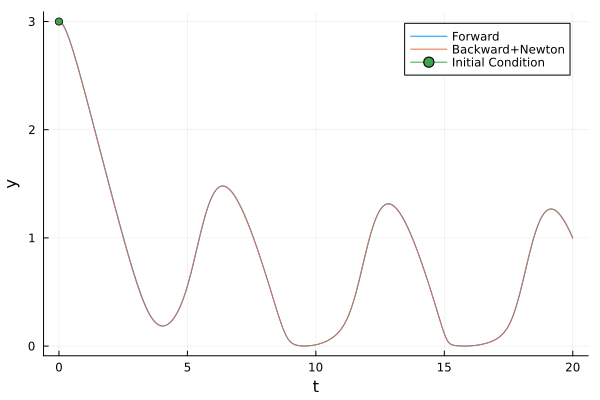

In [7]:
Plots.plot(t,y_for,label="Forward",xlabel="t",ylabel="y")
Plots.plot!(t,y_back,label="Backward+Newton")
Plots.plot!([t_in],[y_in],label="Initial Condition",markershape=:circle)

The two methods return approximatively the same solution.  
We can compute the absolute difference between the two solutions, to see if there places where they diverge more.

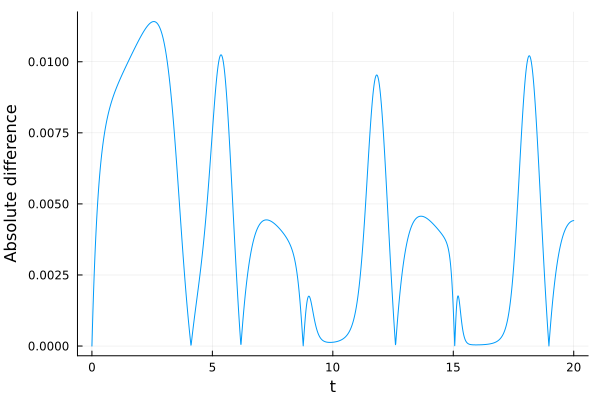

In [8]:
diff = abs.(y_back - y_for);

Plots.plot(t,diff,label="",xlabel="t",ylabel="Absolute difference")

The ODE does not have an analytical solution, so we cannot compute directly which method is more accurate.

## Exercise 2: Pendulum

Let's consider a motorized pendulum like the one in the figure.  
The pendulum has a rigid massless rod and is under a friction force that is linear with the pendulum speed.

![Diagram of the motorized pendulum](Pendulum.png)

The dynamic equation of this mechanical system can be written as follows:
$$T(t)-MgL\sin(\vartheta(t))-r\dot{\vartheta}(t)=ML^{2}\ddot{\vartheta}(t)$$
where the following notation is used:
$$\dot{x}=\frac{\partial x}{\partial t}$$
$$\ddot{x}=\frac{\partial^{2} x}{\partial t^{2}}$$

We can rearrange the terms of the equation as follows:
$$\ddot{\vartheta}(t) = -\frac{r}{ML^{2}}\dot{\vartheta}(t)-\frac{g}{L}\sin(\vartheta(t))+\frac{1}{ML^{2}}T(t)$$

We can apply the following change of variables to obtain a set of first order ODEs.
$$
\begin{cases}
y_{1}=\dot{\vartheta}\\
y_{2}=\vartheta
\end{cases}
$$

$$
\begin{cases}
\dot{y}_{1}(t)=-\frac{r}{ML^{2}}y_{1}(t)-\frac{g}{L}\sin(y_{2}(t))+\frac{1}{ML^{2}}T(t)\\
\dot{y}_{2}(t)=y_{1}(t)
\end{cases}
$$

The first equation of this set is non-linear, so the system has no analytical solution.  
We can solve numerically this dynamical equation using Forward Euler's method.
Let's start by defining the Forward Euler's method for a non-scalar method:

In [9]:
# Define function for Forward Euler in non-scalar case
function forEulerVect(f,t_in,t_end,y_in,h)
    
    # Define time array
    t = range(t_in,t_end,step=h);
    
    # Define output array
    y = ones(length(t),length(y_in));
    y[1,:] = y_in;
    
    # Loop over all time instants
    for i = 2:length(t)
        y_new = reshape(y[i-1,:],(1,length(y_in)))+h*f(t[i-1],y[i-1,:]);
        y[i,:] = y_new;
    end
    
    # Return time and output
    return (t,y)
end

forEulerVect (generic function with 1 method)

Now we can solve the dynamic equation for the following conditions:
$$
T(t) = 0.1\sin\left(\frac{2\pi}{5}t\right) Nm\\
\vartheta(0)=-\frac{\pi}{3}\\
\dot{\vartheta}(0)=0~\frac{[rad]}{s}
$$

In [10]:
# Define system properties
L = 0.3;   # Pendulum length [m]
g = 9.81;  # Gravity acceleration [m/s^2]
M = 0.2;   # Pendulum mass [kg]
r = 0.03;  # Friction coefficient [N*m*s]

# Define initial conditions and torque profile
pos0 = -pi/3;  # Initial pendulum position [rad]
vel0 = 0;      # Initial pendulum velocity [rad/s]
T(t) = @. 0.1 * sin(2pi/5 * t);

# Define time limits
t_in = 0.0;
t_end = 50.0;
h = 0.01;

# Define dynamic equation
f(t,y) = @. [-r/M/L^2 * y[1] - g/L * sin(y[2]) + 1/M/L^2 * T(t) y[1]];

# Apply Forward Euler's method
(t,y) = forEulerVect(f,t_in,t_end,[pos0 vel0],h);

We can now plot both the pendulum position and velocity over time:

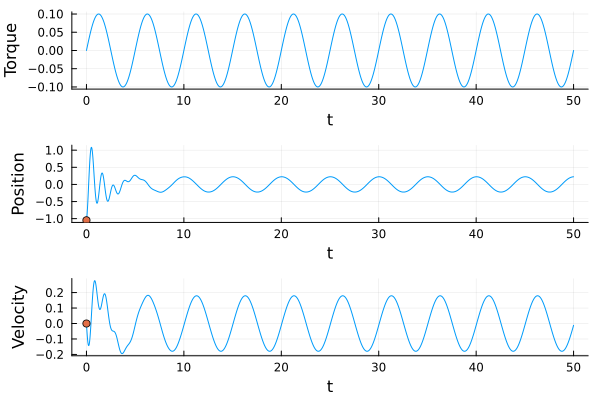

In [11]:
p1 = Plots.plot(t,T(t),label="",xlabel="t",ylabel="Torque")

p2 = Plots.plot(t,y[:,1],label="",xlabel="t",ylabel="Position")
Plots.plot!(p2,[t_in],[pos0],label="",markershape=:circle)

p3 = Plots.plot(t,y[:,2],label="",xlabel="t",ylabel="Velocity")
Plots.plot!(p3,[t_in],[vel0],label="",markershape=:circle)

Plots.plot(p1, p2, p3, layout=(3,1))

## Exercise 3

Let's consider one of the most typical examples in Mechanical Engineering: the horizontal trolley.  
This is a 1-Degree of Freedom (DoF) Linear system.

![Diagram of the 1 Degree of Freedom trolley](Trolley.png)

The system can be represented by the following 2nd order ODE:
$$M\ddot{x}(t)+r\dot{x}(t)+kx(t)=0$$

In our case, we have $M = 0.2~kg$, $r = 9~\frac{Ns}{m}$ and $k = 100~\frac{N}{m}$.
This corresponds to a hyper-dampened system or system with hyper-critical dampening, i.e. the system will move towards the equilibrium position without oscillating.

This system is linear and has constant parameters $M,r,k$, so it has an analytical solution:
$$x(t) = ae^{-20t}+be^{-25t}$$

We consider the Initial Value Problem (IVP) by choosing the following initial conditions. Since it is a second-order ODE, we need to have both an initial speed and initial position.
$$
\begin{cases}
x_{0}=-1~m\\
\dot{x}_{0} = 5~\frac{m}{s}
\end{cases}
$$

For this specific IVP, we can find the values of $a$ and $b$ and obtain the exact equation for the trolley position and speed.
$$
x(t) = -4e^{-20t}+3e^{-25t}\\
\dot{x}(t) = 80e^{-20t}-75e^{-25t}
$$

To apply the Forward and Backward Euler's method, we need to rewrite the dynamical equation in state-space form (as we did in Exercise 2).  
We apply the following change of coordinates:
$$
\begin{cases}
y_{1}=\dot{x}\\
y_{2}=x
\end{cases}\\
\begin{cases}
\dot{y}_{1}(t)=-\frac{r}{M}y_{1}(t)-\frac{k}{M}y_{2}(t)\\
\dot{y}_{2}(t)=y_{1}(t)
\end{cases}\\
\dot{y}(t) = Ay(t) = 
\begin{bmatrix}
    -\frac{r}{M} &-\frac{k}{M}\\
    1 &0
\end{bmatrix} y(t) = 
\begin{bmatrix}
    -45 &-500\\
    1 &0
\end{bmatrix} y(t)
$$

We can use this new formulation to rewrite the core steps of Forward and Backward Euler's method.

For Forward Euler, this becomes:
$$y_{i+1} = y_{i}+hAy_{i} = (I+hA)y_{i} = (I+hA)^{2}y_{i-1} = \dots = (I+hA)^{i+1}y_{0}$$

For Backward Euler, this becomes:
$$y_{i+1} = y_{i}+hAy_{i+1}\\
(I-hA)y_{i+1} = y_{i}\\
y_{i+1} = (I-hA)^{-1}y_{i} = (I-hA)^{-2}y_{i-1} = \dots = (I-hA)^{-(i+1)}y_{0}$$

### Stability analysis - Forward Euler
For Forward Euler, to have a numerically stable method we need the matrix $I+hA$ to have all the eigenvalues between 1 and -1.
$$A^{*} = I+hA\\
A^{*} =
\begin{bmatrix}
    1-45h & -500h\\
    h & 1
\end{bmatrix}
$$

We can find the eigenvalues $\lambda$ of the matrix $A^{*}$, solving the equation $det(A^{*}-\lambda I) = 0$.

$$\det(A^{*}-\lambda I) = \det(I+hA-\lambda I) = 0\\
\det\left(
\begin{bmatrix}
    1-45h-\lambda & -500h\\
    h & 1-\lambda
\end{bmatrix}\right) = 0\\
(1-45h-\lambda)(1-\lambda)+500h^{2}=0\\
\lambda^{2}+(45h-2)\lambda+(500h^{2}-45h+1)=0\\
\lambda_{1,2}=\frac{-(45h-2)\pm\sqrt{(45h-2)^{2}-4(500h^{2}-45h+1)}}{2}=1-\frac{(45\pm 5)h}{2}\\
\lambda_{1}=1-\frac{(45+5)h}{2}=1-25h\\
\lambda_{2}=1-\frac{(45-5)h}{2}=1-20h
$$

By adding the condition $|\lambda_{i}| < 1$, we obtain the following equations:
$$
\lambda_{1}:\quad 0<h<0.08s\\
\lambda_{2}:\quad 0<h<0.10s\\
$$

Therefore, the Forward Euler's method is stable with $h < 0.08s$.

Let's check this hypothesis using some numerical results.
We can solve the equation for $h = 0.02s$ and $h = 0.08s$.

In [12]:
# Define initial conditions and torque profile
pos0 = -1;     # Initial trolley position [m]
vel0 = 5;      # Initial trolley velocity [m/s]

# Define time limits
t_in = 0.0;
t_end = 3.0;
t = t_in:0.001:t_end;

# Define dynamic equation
f(t,y) = ([-45 -500; 1 0] * reshape(y,(2,1)))';

# Define accurate solution
pos(t) = @. -4 * exp(-20 * t) + 3 * exp(-25 * t);
vel(t) = @. 80 * exp(-20 * t) - 75 * exp(-25 * t);

**Case 1**: $h=0.02s$

In [13]:
h1 = 0.02;
# Apply Forward Euler's method
(t_for1,y_for1) = forEulerVect(f,t_in,t_end,[vel0 pos0],h1);

**Case 2**: $h=0.08s$

In [14]:
h2 = 0.08;
# Apply Forward Euler's method
(t_for2,y_for2) = forEulerVect(f,t_in,t_end,[vel0 pos0],h2);

**Comparison**

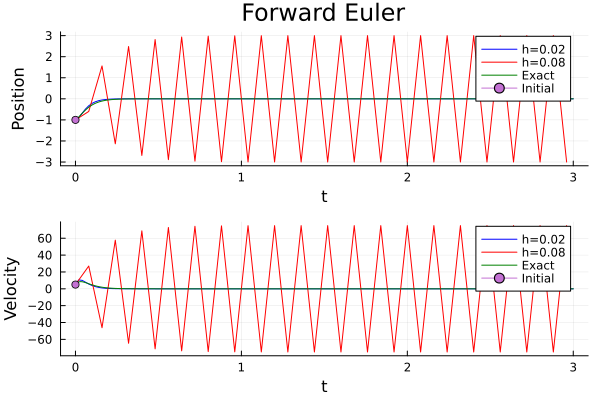

In [15]:
p1 = Plots.plot(t_for1,y_for1[:,2],color=:blue,label="h=$(h1)",xlabel="t",ylabel="Position");
Plots.plot!(p1,t_for2,y_for2[:,2],color=:red,label="h=$(h2)")
Plots.plot!(p1,t,pos(t),color=:green,label="Exact")
Plots.plot!(p1,[t_in],[pos0],label="Initial",markershape=:circle,legend=:topright)

p2 = Plots.plot(t_for1,y_for1[:,1],color=:blue,label="h=$(h1)",xlabel="t",ylabel="Velocity");
Plots.plot!(p2,t_for2,y_for2[:,1],color=:red,label="h=$(h2)")
Plots.plot!(p2,t,vel(t),color=:green,label="Exact")
Plots.plot!(p2,[t_in],[vel0],label="Initial",markershape=:circle,legend=:topright)

Plots.plot(p1, p2, layout=(2,1), sgtitle="Forward Euler")

It's clear from both the position and velocity plots that the solution converges for $h=0.02s$ (blue line), but not for $h=0.08s$ (red line).
For $h > 0.08s$, the error actually diverges and goes to infinity.
This matches our prediction that the Forward Euler's method is stable only for $h < 0.08s$.

### Stability analysis - Backward Euler
For Backward Euler, to have a numerically stable method we need the matrix $(I-hA)^{-1}$ to have all the eigenvalues between 1 and -1.
$$A^{*} = (I-hA)^{-1}\\
A^{*} = 
\begin{bmatrix}
    1+45h & 500h\\
    -h & 1
\end{bmatrix}^{-1}\\
A^{*} = 
\frac{1}{500h^{2}+45h+1}
\begin{bmatrix}
    1 & -500h\\
    h & 1+45h
\end{bmatrix}\\
$$

We can find the eigenvalues as we did for Forward Euler.
$$\det(A^{*}-\lambda I) = 0\\
\det\left(
\begin{bmatrix}
    \frac{1}{500h^{2}+45h+1}-\lambda & -\frac{500h}{500h^{2}+45h+1}\\
    \frac{h}{500h^{2}+45h+1} & \frac{1+45h}{500h^{2}+45h+1}-\lambda
\end{bmatrix}\right) = 0\\
\left(\frac{1}{500h^{2}+45h+1}-\lambda\right)\left(\frac{1+45h}{500h^{2}+45h+1}-\lambda\right)+\frac{500h^{2}}{(500h^{2}+45h+1)^{2}}=0\\
\lambda^{2}-\frac{2+45h}{500h^{2}+45h+1}\lambda+\frac{1}{500h^{2}+45h+1}=0\\
(500h^{2}+45h+1)\lambda^{2}-(2+45h)\lambda+1=0\\
\lambda_{1,2}=\frac{(2+45h)\pm\sqrt{(2+45h)^{2}-4(500h^{2}+45h+1)}}{2(500h^{2}+45h+1)}=\frac{2+(45\pm 5)h}{2(500h^{2}+45h+1)}\\
\lambda_{1}=\frac{2+(45+5)h}{2(500h^{2}+45h+1)}=\frac{1+25h}{500h^{2}+45h+1}\\
\lambda_{2}=\frac{2+(45-5)h}{2(500h^{2}+45h+1)}=\frac{1+20h}{500h^{2}+45h+1}
$$

Since $h>0$ by definition, the eigenvalues of $(I-hA)^{-1}$ will be between $0$ and $1$ for any $h > 0$. Therefore, the method is always stable.

We can test this hypothesis by testing the Backward Euler method with two different values of h.  
First, we need to implement the Backward Euler's method for a non-scalar case.
Since the system is linear, we don't need to use a root finding algorithm.
$$y_{i+1} = y_{i}+hf(t_{i+1},y_{i+1})\\
y_{i+1} = y_{i}+hAy_{i+1}\\
y_{i+1} = (I-hA)^{-1}y_{i}\\
y_{i+1} = G(h,t_{i+1})y_{i}$$

In [16]:
# Define function for Forward Euler in non-scalar case
function backEulerVect(g,t_in,t_end,y_in,h)
    
    # Define time array
    t = range(t_in,t_end,step=h);
    
    # Define output array
    y = ones(length(t),length(y_in));
    y[1,:] = y_in;
    
    # Loop over all time instants
    for i = 2:length(t)
        y_new = g(h,t[i]) * reshape(y[i-1,:],(2,1));
        y[i,:] = vec(y_new);
    end
    
    # Return time and output
    return (t,y)
end

backEulerVect (generic function with 1 method)

Let's test the Backward Euler's method with the same values of h used before: $h = 0.02s$ and $h = 0.08s$.

**Case 1**: $h=0.02s$

In [17]:
# Define equation for linear Backward Euler
G(h,t) = inv([1+45*h 500*h; -h 1]);

# Apply Backward Euler's method
(t_back1,y_back1) = backEulerVect(G,t_in,t_end,[vel0 pos0],h1);

**Case 2**: $h=0.08s$

In [18]:
# Apply Backward Euler's method
(t_back2,y_back2) = backEulerVect(G,t_in,t_end,[vel0 pos0],h2);

**Comparison**

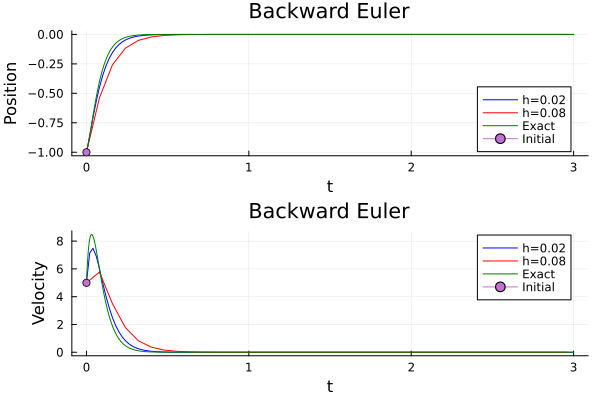

In [19]:
p1 = Plots.plot(t_back1,y_back1[:,2],color=:blue,label="h=$(h1)",xlabel="t",ylabel="Position");
Plots.plot!(p1,t_back2,y_back2[:,2],color=:red,label="h=$(h2)")
Plots.plot!(p1,t,pos(t),color=:green,label="Exact")
Plots.plot!(p1,[t_in],[pos0],label="Initial",markershape=:circle)

p2 = Plots.plot(t_back1,y_back1[:,1],color=:blue,label="h=$(h1)",xlabel="t",ylabel="Velocity");
Plots.plot!(p2,t_back2,y_back2[:,1],color=:red,label="h=$(h2)")
Plots.plot!(p2,t,vel(t),color=:green,label="Exact")
Plots.plot!(p2,[t_in],[vel0],label="Initial",markershape=:circle)

Plots.plot(p1, p2, layout=(2,1), title="Backward Euler")

This plot shows that both solutions are stable and seems to confirm our hypothesis that Backward Euler's method is stable for any positive value of $h$ (for this specific system).

**Note**: It may not always be true that Backward Euler is stable for any value of $h$, but in general it is true that Backward Euler is more stable than Forward Euler.